In [ ]:
# Matematyka Użytkowa 2020/2021
# Projekt 1
# Maciej Bartczak, Wojciech Matusiak, Karol Mućk, Marcin Pracki

Matematyka Użytkowa 2020/2021 Projekt 1

Maciej Bartczak, Wojciech Matusiak, Karol Mućk, Marcin Pracki

Do uruchomienia tego notebooka potrzebny jest plik z danymi - `Merged.csv`

# Przygotowanie danych

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from keras.models import Sequential
from keras.layers import Dense, Conv2D
from datetime import date, timedelta, datetime
from sklearn import preprocessing
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from keras.layers import LeakyReLU

In [ ]:
df = pd.read_csv('Merged.csv', index_col=0)

df.index = pd.DatetimeIndex(df.index)
df['month'] = df.index.month
df['weekday'] = df.index.weekday
df = df[df.index.year >= 2016]

df = df.dropna(how='all', axis=1)
with_any_measurements = df.iloc[:, 3:].dropna(how='all').index
df = df.loc[with_any_measurements]

In [ ]:
# fill NaNs based on gaussian conditioning

mean = df.mean()
cov = df.cov()
print(f"NaNs proportion: {df.isna().mean().mean():.4f}", flush=True)
for idx, row in tqdm(df.iterrows(), total=len(df)):
  missing = row.isna()
  if missing.any():
    conditional_mean = mean[missing] + cov.loc[missing, ~missing]@np.linalg.solve(cov.loc[~missing, ~missing], row[~missing] - mean[~missing])
    df.loc[idx, missing] = conditional_mean

NaNs proportion: 0.0000


100%|██████████| 1886/1886 [00:00<00:00, 4845.04it/s]


## Podgląd przygotowanych danych

In [ ]:
df

,Dzień Roboczy,Święto,Ferie,"('Średnia dobowa wilgotność względna [%]', 'East')","('Średnia dobowa wilgotność względna [%]', 'North')","('Średnia dobowa wilgotność względna [%]', 'Warsaw')","('Średnia dobowa wilgotność względna [%]', 'West')","('Średnia dobowa prędkość wiatru [m/s]', 'East')","('Średnia dobowa prędkość wiatru [m/s]', 'North')","('Średnia dobowa prędkość wiatru [m/s]', 'Warsaw')","('Średnia dobowa prędkość wiatru [m/s]', 'West')","('Maksymalna temperatura dobowa [°C]', 'East')","('Maksymalna temperatura dobowa [°C]', 'North')","('Maksymalna temperatura dobowa [°C]', 'Warsaw')","('Maksymalna temperatura dobowa [°C]', 'West')","('Suma dobowa opadów [mm]', 'East')","('Suma dobowa opadów [mm]', 'North')","('Suma dobowa opadów [mm]', 'Warsaw')","('Suma dobowa opadów [mm]', 'West')","('Temperatura powietrza [°C]', 'East')","('Temperatura powietrza [°C]', 'North')","('Temperatura powietrza [°C]', 'Warsaw')","('Temperatura powietrza [°C]', 'West')","('Wilgotność względna [%]', 'East')","('Wilgotność względna [%]', 'North')","('Wilgotność względna [%]', 'Warsaw')","('Wilgotność względna [%]', 'West')","('Prędkość wiatru [m/s]', 'East')","('Prędkość wiatru [m/s]', 'North')","('Prędkość wiatru [m/s]', 'Warsaw')","('Prędkość wiatru [m/s]', 'West')","('Zachmurzenie ogólne [0-10 do dn.31.12.1988/oktanty od dn.01.01.1989]', 'East')","('Zachmurzenie ogólne [0-10 do dn.31.12.1988/oktanty od dn.01.01.1989]', 'North')","('Zachmurzenie ogólne [0-10 do dn.31.12.1988/oktanty od dn.01.01.1989]', 'Warsaw')","('Zachmurzenie ogólne [0-10 do dn.31.12.1988/oktanty od dn.01.01.1989]', 'West')","('Widzialność [kod]', 'East')","('Widzialność [kod]', 'North')","('Widzialność [kod]', 'Warsaw')","('Widzialność [kod]', 'West')","('PM10', 'East')","('PM10', 'North')","('PM10', 'South')","('PM10', 'Warsaw')","('PM10', 'West')","('NOx', 'East')","('NOx', 'North')","('NOx', 'South')","('NOx', 'Warsaw')","('NOx', 'West')","('CO', 'East')","('CO', 'South')","('CO', 'Warsaw')","('CO', 'West')","('PM2.5', 'South')","('PM2.5', 'West')",month,weekday
2016-01-01,0,1,0,66.300000,84.300000,69.500000,71.000000,5.000000,2.300000,3.000000,2.700000,-10.200000,-10.050000,-9.000000,-8.600000,-1.748148,-3.360975,-2.831159,-4.012106,-10.333333,-9.866667,-9.355556,-8.600000,68.666667,82.666667,66.000000,70.000000,5.000000,2.333333,3.000000,2.666667,3.333333,0.000000,3.500000,0.333333,7.000000,8.000000,7.666667,6.666667,44.335000,42.815000,57.880000,45.819026,66.698571,14.842174,9.897696,20.366391,35.267391,17.412989,0.421356,0.585765,0.481710,0.515954,44.270000,47.720000,1,4
2016-01-02,0,0,0,64.300000,84.300000,37.500000,53.800000,5.700000,3.650000,4.800000,4.000000,-12.200000,-11.200000,-11.233333,-10.900000,-2.058034,-1.963694,-0.791476,-4.091065,-12.466667,-11.083333,-11.144444,-10.400000,65.333333,84.333333,39.333333,50.333333,5.666667,3.666667,4.833333,4.000000,2.000000,0.000000,3.666667,0.333333,7.000000,8.000000,7.500000,7.000000,22.075000,17.320000,22.860000,21.831025,30.065714,7.687917,3.329250,12.386271,25.500000,9.127686,0.275741,0.305036,0.300125,0.328589,18.510000,17.780000,1,5
2016-01-03,0,0,0,56.500000,79.800000,62.500000,55.800000,5.000000,1.650000,2.150000,2.700000,-14.900000,-15.950000,-14.733333,-15.000000,3.052238,1.496347,2.137888,2.251993,-14.966667,-15.216667,-14.533333,-14.333333,57.666667,80.000000,64.666667,61.333333,5.000000,1.666667,2.166667,2.666667,8.000000,0.000000,4.333333,0.000000,7.000000,8.000000,6.500000,7.000000,39.700000,43.535000,37.190000,29.031020,47.960000,14.823333,12.742333,18.424271,49.962500,19.352623,0.425102,0.416087,0.435708,0.411404,38.100000,31.570000,1,6
2016-01-04,1,0,0,53.300000,77.500000,69.300000,52.500000,5.300000,2.000000,3.150000,3.300000,-14.700000,-15.250000,-14.233333,-13.700000,-1.168622,-0.300116,0.085817,-1.254672,-14.100000,-14.350000,-13.611111,-12.700000,55.666667,73.666667,70.000000,53.000000,5.333333,2.000000,3.166667,3.333333,2.333333,0.000000,2.166667,0.000000,7.000000,8.000000,6.500000,6.666667,

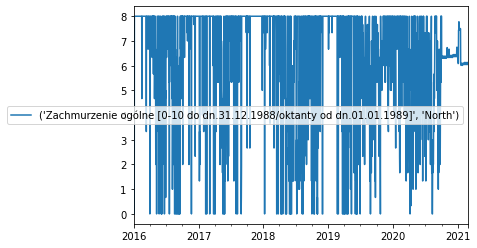

In [ ]:
#df["('PM10', 'Warsaw')"].plot()
#df["('Suma dobowa opadów [mm]', 'Warsaw')"].plot()
df[random.choice(df.columns)].plot()
plt.legend()

In [ ]:
# data preparation
cutoff = 55
y = df["('PM10', 'Warsaw')"].shift(-1) >= cutoff
y = y[:-1]
x = df[:-1]
y.mean()

0.15225464190981433

## Rozkład zmiennej docelowej

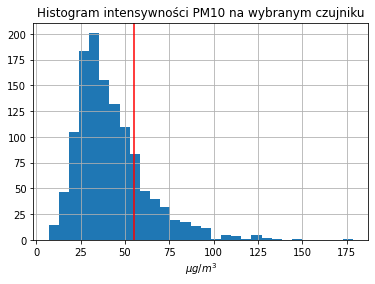

In [ ]:
df["('PM10', 'Warsaw')"].hist(bins=30)
plt.axvline(55, c='red')
plt.xlabel("$\mu g / m^3$")
plt.title("Histogram intensywności PM10 na wybranym czujniku");

# Modele

Uruchomienie poniższych komórek poskutuje przygotowaniem ograniczonych/rozszerzonych zbiorów danych i wytrenowaniem modeli. Funkcja `keras_cv`, której wynik wypisuje się **na samym końcu** po uruchomieniu komórek w których ta funkcja jest wywoływana, zwraca średnią wartość metryki accuracy wraz z odchyleniem standardowym w pięcioczęściowej walidacji krzyżowej. Wartości te wykorzstujemy do porównania modeli i stanowią kryterium doboru ostatecznego modelu.

Przy trenowaniu modeli pojawiają się dodatkowe informacje diagnostyczne.

In [ ]:
from keras.layers import GaussianDropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

def fit_model(model, x_train, y_train, x_test, y_test):
  model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])

  history = model.fit(
      x_train, y_train, epochs=400, batch_size=10, validation_data=(x_test, y_test), verbose=0,
      callbacks=[EarlyStopping(
          monitor='val_accuracy',
          patience=40,
          restore_best_weights=True,
      )]
  )

  train_data = pd.DataFrame(history.history)
  train_data[['loss', 'val_loss']].plot(); plt.ylim(0, 1); plt.show()
  train_data[['accuracy', 'val_accuracy']].plot(); plt.show()

  test_acc = model.evaluate(x_test, y_test)[1]
  print(f"test acc: {test_acc}", flush=True)
  return test_acc

In [ ]:
from sklearn.model_selection import KFold
from keras.models import clone_model

def keras_cv(model, x, y, splits=5):
  model.save_weights('my_model_weights.h5')    
  kf = KFold(n_splits=splits)
  accs = []
  for train_index, test_index in tqdm(kf.split(x)):
    model.load_weights('my_model_weights.h5')
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    acc = fit_model(model, X_train, y_train, X_test, y_test)
    accs.append(acc)

  return np.mean(accs), np.std(accs)





0it [00:00, ?it/s]

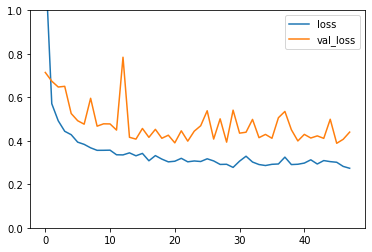

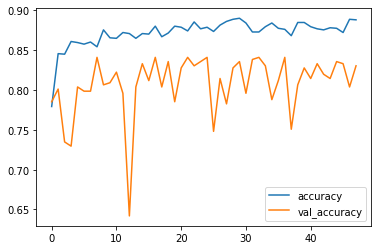

12/12 [==============================] - 0s 1ms/step - loss: 0.5956 - accuracy: 0.8408
test acc: 0.8408488035202026






1it [00:13, 13.24s/it]

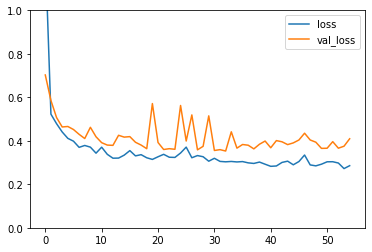

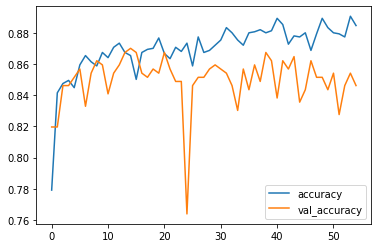

12/12 [==============================] - 0s 1ms/step - loss: 0.4170 - accuracy: 0.8700
test acc: 0.8700265288352966






2it [00:28, 13.97s/it]

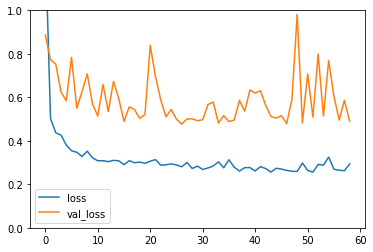

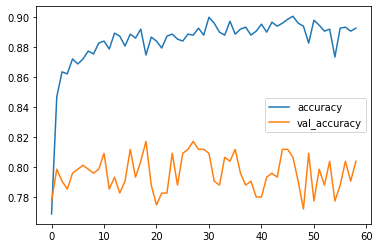

12/12 [==============================] - 0s 1ms/step - loss: 0.5027 - accuracy: 0.8170
test acc: 0.8169761300086975






3it [00:45, 14.61s/it]

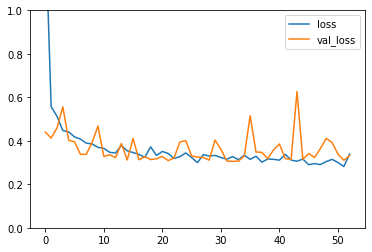

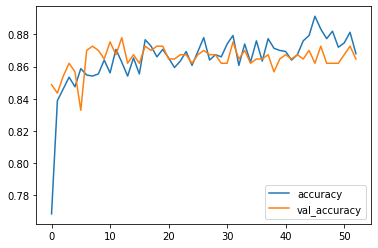

12/12 [==============================] - 0s 1ms/step - loss: 0.3229 - accuracy: 0.8780
test acc: 0.8779841065406799






4it [00:59, 14.58s/it]

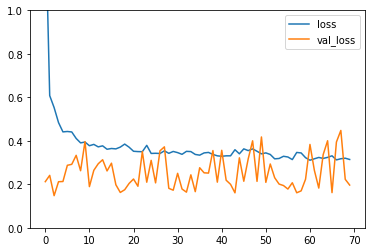

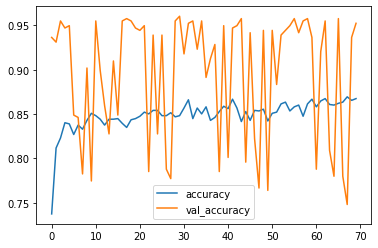

12/12 [==============================] - 0s 1ms/step - loss: 0.1729 - accuracy: 0.9602
test acc: 0.960212230682373






5it [01:18, 15.66s/it]


(0.87320955991745, 0.048604135413484136)

In [ ]:
# low dropout - many hidden neurons

model = Sequential()
model.add(Dense(100, input_dim=len(x.columns), activation=LeakyReLU()))
model.add(GaussianDropout(0.0001))
model.add(Dense(50, activation=LeakyReLU()))
model.add(GaussianDropout(0.0001))
model.add(Dense(1, activation='sigmoid'))

#fit_model(model, x_train, y_train, x_test, y_test)
keras_cv(model, x, y)





0it [00:00, ?it/s]

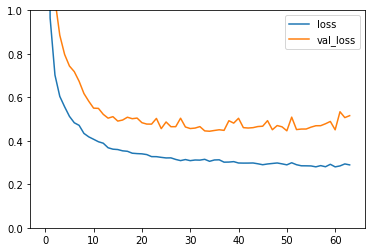

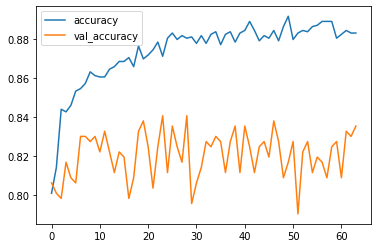

12/12 [==============================] - 0s 1ms/step - loss: 0.5030 - accuracy: 0.8408






1it [00:16, 16.54s/it]

test acc: 0.8408488035202026


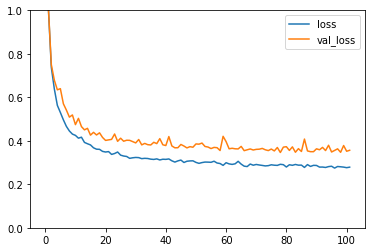

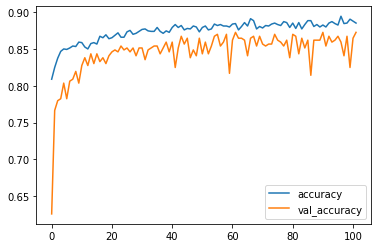

12/12 [==============================] - 0s 2ms/step - loss: 0.3633 - accuracy: 0.8727






2it [00:42, 19.41s/it]

test acc: 0.8726790547370911


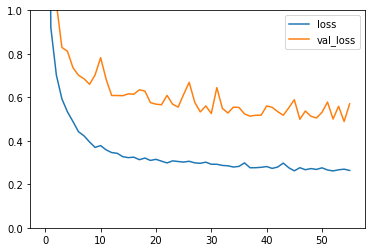

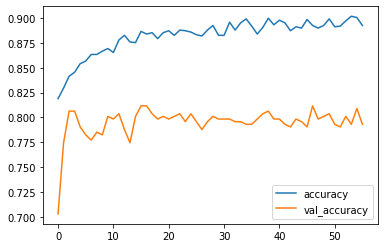

12/12 [==============================] - 0s 1ms/step - loss: 0.6160 - accuracy: 0.8117






3it [00:57, 17.96s/it]

test acc: 0.8116710782051086


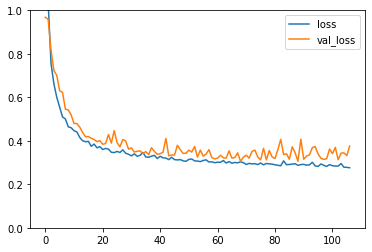

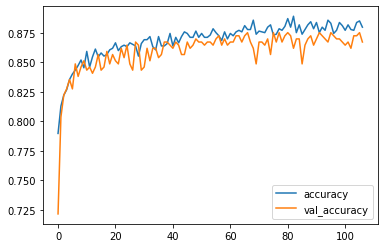

12/12 [==============================] - 0s 1ms/step - loss: 0.3232 - accuracy: 0.8753






4it [01:23, 20.56s/it]

test acc: 0.8753315806388855


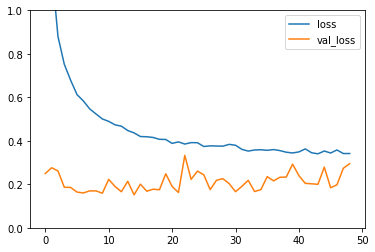

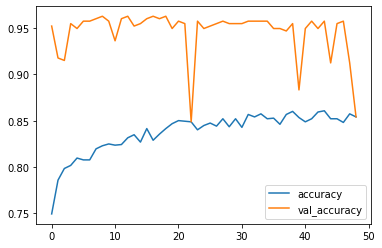

12/12 [==============================] - 0s 1ms/step - loss: 0.1697 - accuracy: 0.9629






5it [01:37, 19.46s/it]

test acc: 0.9628646969795227


(0.8726790428161622, 0.05074568760672377)

In [ ]:
# low dropout

model = Sequential()
model.add(Dense(40, input_dim=len(x.columns), activation=LeakyReLU()))
model.add(GaussianDropout(0.0001))
model.add(Dense(20, activation=LeakyReLU()))
model.add(GaussianDropout(0.0001))
model.add(Dense(1, activation='sigmoid'))

#fit_model(model, x_train, y_train, x_test, y_test)
keras_cv(model, x, y)





0it [00:00, ?it/s]

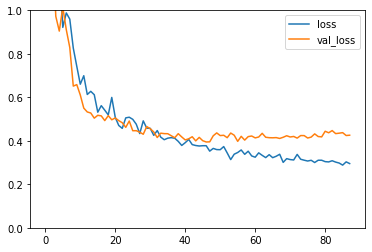

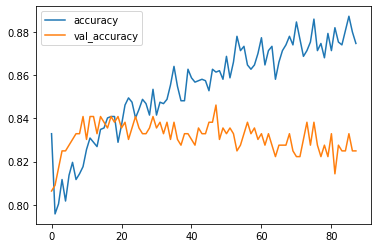

12/12 [==============================] - 0s 1ms/step - loss: 0.3953 - accuracy: 0.8462






1it [00:23, 23.38s/it]

test acc: 0.8461538553237915


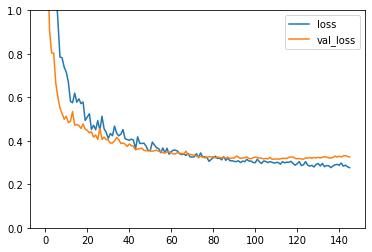

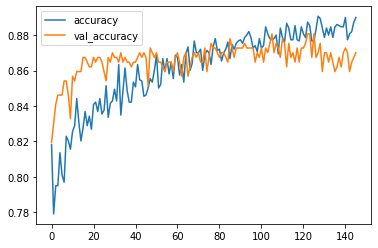

12/12 [==============================] - 0s 1ms/step - loss: 0.3193 - accuracy: 0.8806






2it [01:00, 27.41s/it]

test acc: 0.8806366324424744


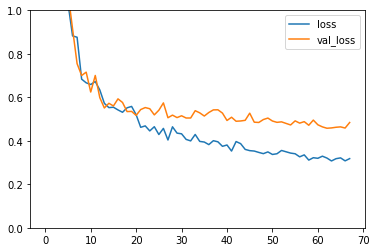

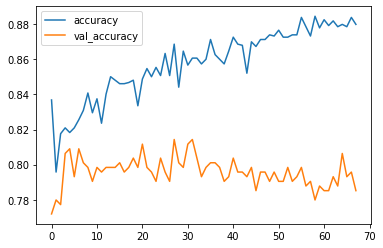

12/12 [==============================] - 0s 2ms/step - loss: 0.5061 - accuracy: 0.8143






3it [01:18, 24.61s/it]

test acc: 0.8143236041069031


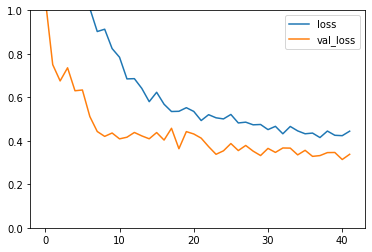

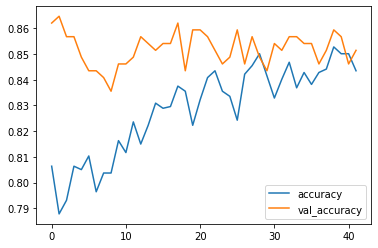

12/12 [==============================] - 0s 1ms/step - loss: 0.7504 - accuracy: 0.8647






4it [01:29, 20.70s/it]

test acc: 0.8647214770317078


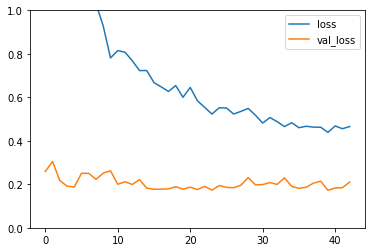

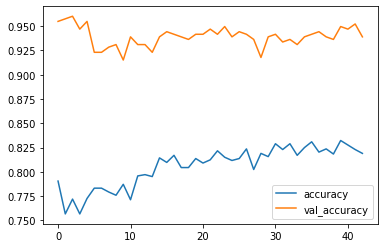

12/12 [==============================] - 0s 1ms/step - loss: 0.2174 - accuracy: 0.9602






5it [01:41, 20.34s/it]

test acc: 0.960212230682373


(0.87320955991745, 0.04877753708496934)

In [ ]:
# high dropout
model = Sequential()
model.add(Dense(40, input_dim=len(x.columns), activation=LeakyReLU()))
model.add(GaussianDropout(0.05))
model.add(Dense(20, activation=LeakyReLU()))
model.add(GaussianDropout(0.05))
model.add(Dense(1, activation='sigmoid'))

#fit_model(model, x_train, y_train, x_test, y_test)
keras_cv(model, x, y)

In [ ]:
warsaw_cols = [c for c in x.columns if 'warsaw' in c.lower()]
x_waw = x[warsaw_cols]





0it [00:00, ?it/s]

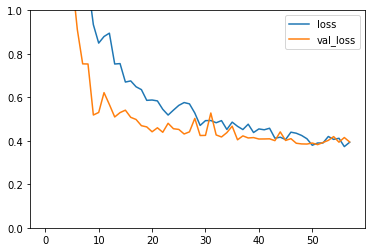

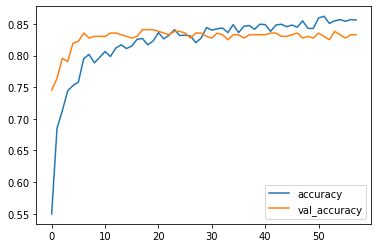

12/12 [==============================] - 0s 1ms/step - loss: 0.4982 - accuracy: 0.8408






1it [00:15, 15.04s/it]

test acc: 0.8408488035202026


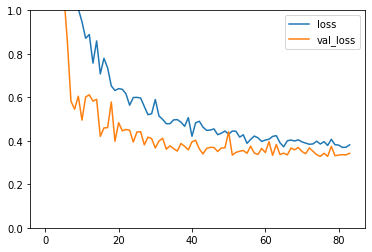

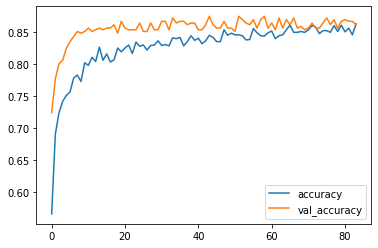

12/12 [==============================] - 0s 1ms/step - loss: 0.3398 - accuracy: 0.8753






2it [00:36, 16.85s/it]

test acc: 0.8753315806388855


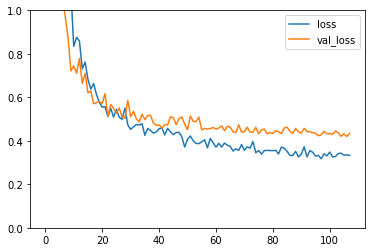

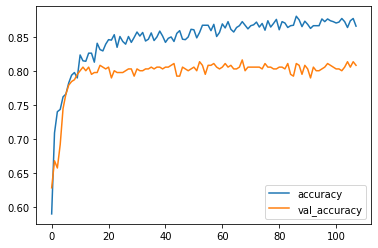

12/12 [==============================] - 0s 1ms/step - loss: 0.4377 - accuracy: 0.8170






3it [01:03, 19.92s/it]

test acc: 0.8169761300086975


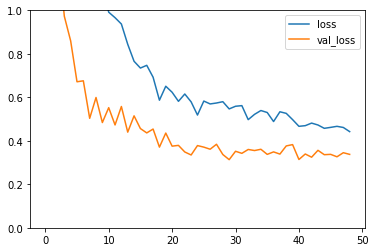

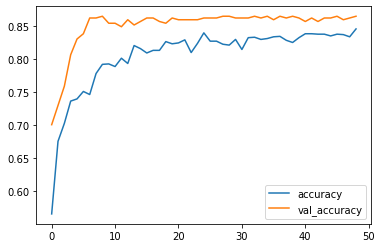

12/12 [==============================] - 0s 1ms/step - loss: 0.5993 - accuracy: 0.8647






4it [01:16, 17.80s/it]

test acc: 0.8647214770317078


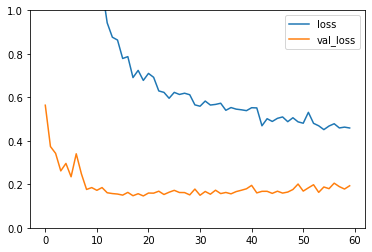

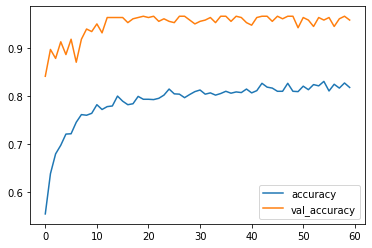

12/12 [==============================] - 0s 2ms/step - loss: 0.1465 - accuracy: 0.9655






5it [01:31, 18.35s/it]

test acc: 0.9655172228813171


(0.8726790428161622, 0.05060684759357985)

In [ ]:
# warsaw data with dropout

model = Sequential()
model.add(Dense(40, input_dim=len(x_waw.columns), activation=LeakyReLU()))
model.add(GaussianDropout(0.05))
model.add(Dense(20, activation=LeakyReLU()))
model.add(GaussianDropout(0.05))
model.add(Dense(1, activation='sigmoid'))

#fit_model(model, x_train, y_train, x_test, y_test)
keras_cv(model, x_waw, y)

0it [00:00, ?it/s]

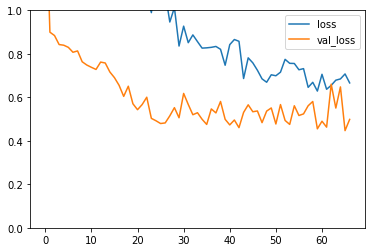

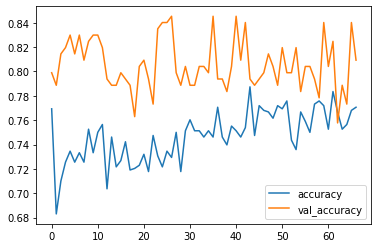

7/7 [==============================] - 0s 2ms/step - loss: 0.4823 - accuracy: 0.8454
test acc: 0.8453608155250549


1it [00:10, 10.76s/it]

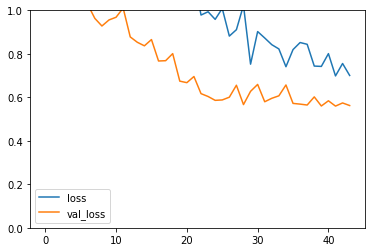

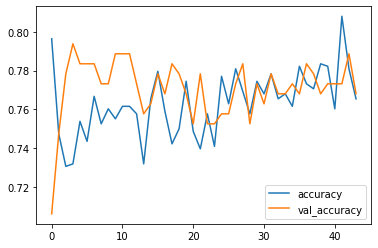

7/7 [==============================] - 0s 2ms/step - loss: 1.1976 - accuracy: 0.7938
test acc: 0.7938144207000732


2it [00:18,  9.75s/it]

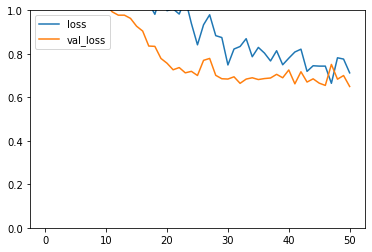

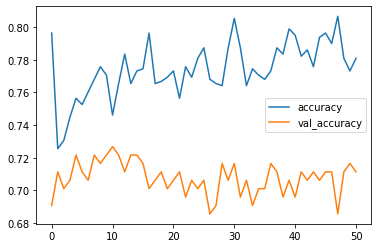

7/7 [==============================] - 0s 2ms/step - loss: 1.0243 - accuracy: 0.7268
test acc: 0.7268041372299194


3it [00:26,  9.39s/it]

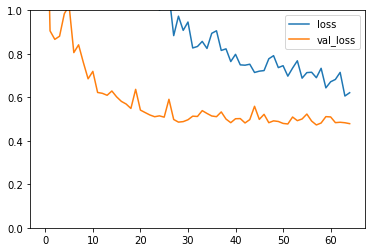

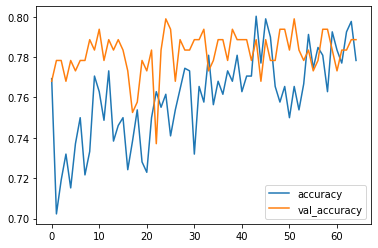

7/7 [==============================] - 0s 2ms/step - loss: 0.5148 - accuracy: 0.7990
test acc: 0.7989690899848938


4it [00:37,  9.69s/it]

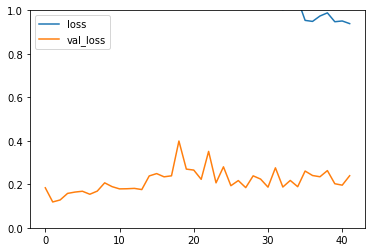

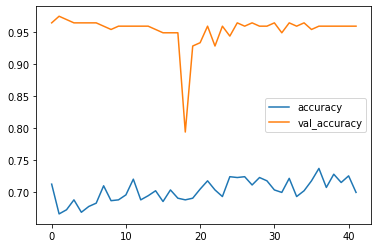

7/7 [==============================] - 0s 2ms/step - loss: 0.1188 - accuracy: 0.9742
test acc: 0.9742268323898315


5it [00:44,  8.85s/it]


(0.8278350591659546, 0.08238397733688627)

In [ ]:
# model tylko dla mieisęcy zimnych

winter_idxs = np.isin(x_waw.index.month, [10, 11, 12, 1, 2, 3])

model = Sequential()
model.add(Dense(40, input_dim=len(x_waw.columns), activation=LeakyReLU()))
model.add(GaussianDropout(0.05))
model.add(Dense(20, activation=LeakyReLU()))
model.add(GaussianDropout(0.05))
model.add(Dense(1, activation='sigmoid'))

#fit_model(model, x_train, y_train, x_test, y_test)
keras_cv(model, x_waw[winter_idxs], y[winter_idxs])

Modele z danymi z przeszłości dalszej niż 1 dzień

In [ ]:
lag = 7

x_with_lag = np.concatenate([x.shift(j) for j in range(lag)], axis=-1)[lag:]
x_with_lag = pd.DataFrame(x_with_lag)
y_lag = y[lag:]
print(x_with_lag.shape, y_lag.shape)

(1226, 399) (1226,)






0it [00:00, ?it/s]

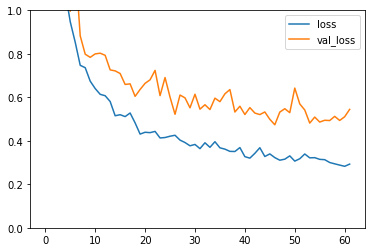

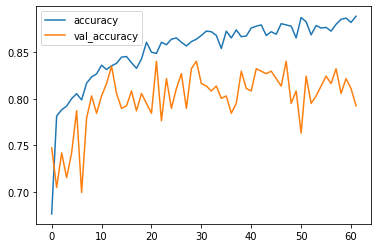

12/12 [==============================] - 0s 1ms/step - loss: 0.6807 - accuracy: 0.8404
test acc: 0.8404255509376526






1it [00:21, 21.83s/it]

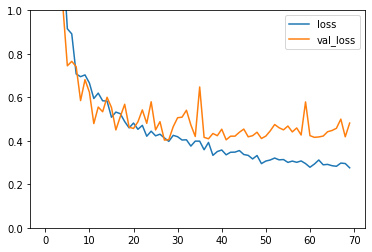

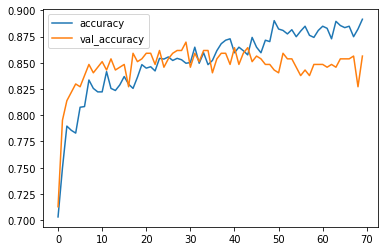

12/12 [==============================] - 0s 2ms/step - loss: 0.4649 - accuracy: 0.8697
test acc: 0.8696808218955994






2it [00:43, 21.68s/it]

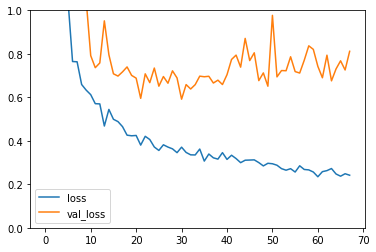

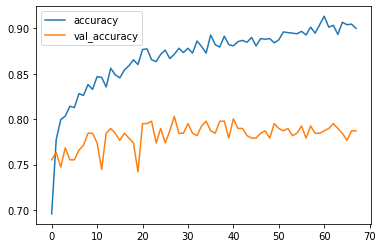

12/12 [==============================] - 0s 1ms/step - loss: 0.6649 - accuracy: 0.8032
test acc: 0.8031914830207825






3it [01:03, 21.35s/it]

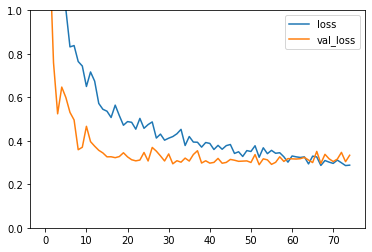

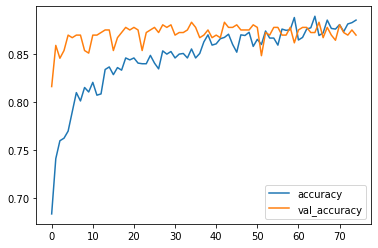

12/12 [==============================] - 0s 2ms/step - loss: 0.3205 - accuracy: 0.8827
test acc: 0.8826666474342346






4it [01:25, 21.54s/it]

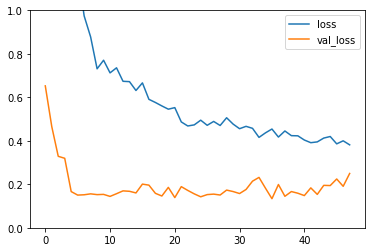

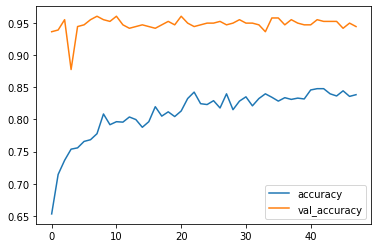

12/12 [==============================] - 0s 1ms/step - loss: 0.1561 - accuracy: 0.9600
test acc: 0.9599999785423279






5it [01:40, 20.01s/it]


(0.8711928963661194, 0.05213722842481615)

In [ ]:
model = Sequential()
model.add(Dense(40, input_dim=len(x_with_lag.columns), activation=LeakyReLU()))
model.add(GaussianDropout(0.05))
model.add(Dense(20, activation=LeakyReLU()))
model.add(GaussianDropout(0.05))
model.add(Dense(1, activation='sigmoid'))

#fit_model(model, x_train, y_train, x_test, y_test)
keras_cv(model, x_with_lag, y_lag)

In [ ]:
x_waw_with_lag = np.concatenate([x_waw.shift(j) for j in range(lag)], axis=-1)[lag:]
x_waw_with_lag = pd.DataFrame(x_waw_with_lag)
y_lag = y[lag:]
print(x_waw_with_lag.shape, y_lag.shape)

(1226, 84) (1226,)






0it [00:00, ?it/s]

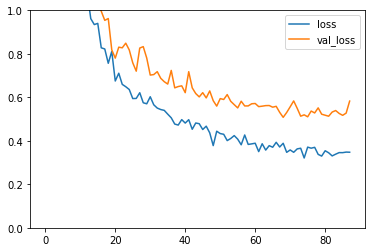

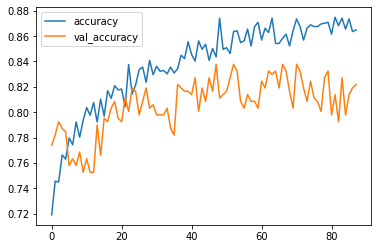

12/12 [==============================] - 0s 1ms/step - loss: 0.6295 - accuracy: 0.8378
test acc: 0.8377659320831299






1it [00:25, 25.74s/it]

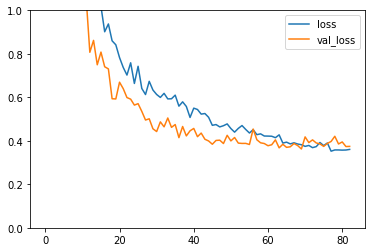

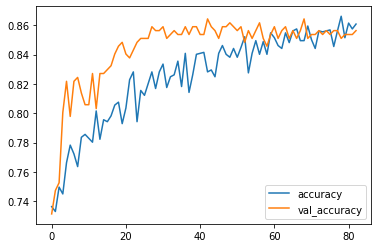

12/12 [==============================] - 0s 2ms/step - loss: 0.4356 - accuracy: 0.8644
test acc: 0.8643617033958435






2it [00:50, 25.34s/it]

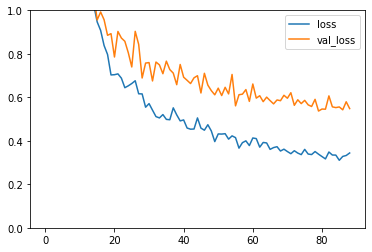

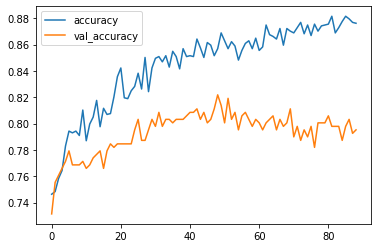

12/12 [==============================] - 0s 1ms/step - loss: 0.6308 - accuracy: 0.8218
test acc: 0.8218085169792175






3it [01:19, 26.59s/it]

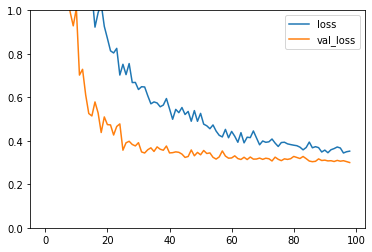

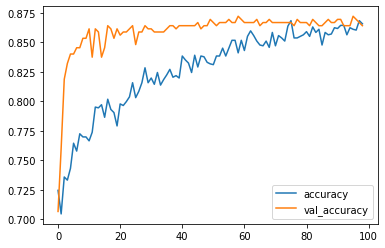

12/12 [==============================] - 0s 1ms/step - loss: 0.3299 - accuracy: 0.8720
test acc: 0.871999979019165






4it [01:49, 27.44s/it]

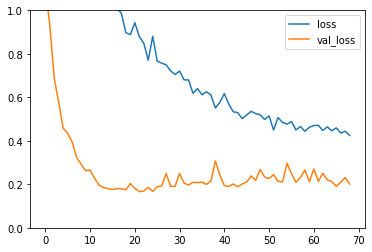

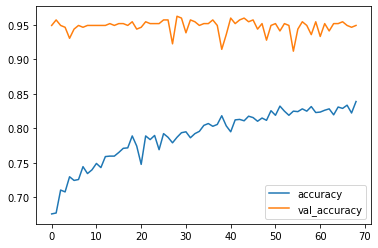

12/12 [==============================] - 0s 1ms/step - loss: 0.1907 - accuracy: 0.9627
test acc: 0.9626666903495789






5it [02:09, 25.85s/it]


(0.8717205643653869, 0.04892761646872416)

In [ ]:
model = Sequential()
model.add(Dense(40, input_dim=len(x_waw_with_lag.columns), activation=LeakyReLU()))
model.add(GaussianDropout(0.05))
model.add(Dense(20, activation=LeakyReLU()))
model.add(GaussianDropout(0.05))
model.add(Dense(1, activation='sigmoid'))

#fit_model(model, x_train, y_train, x_test, y_test)
keras_cv(model, x_waw_with_lag, y_lag)

In [ ]:
%%time
# Model "standardowy"
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

model = Pipeline([
  ('norm', StandardScaler()),
  ('model', LogisticRegressionCV(verbose=0, penalty='elasticnet', solver='saga', l1_ratios=np.linspace(0, 1, 5)))
])

result = cross_val_score(model, x_waw, y)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

CPU times: user 25.7 s, sys: 58.5 ms, total: 25.8 s
Wall time: 25.7 s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [ ]:
np.mean(result), np.std(result)

(0.8604774535809018, 0.01690968429762251)

# Ostateczny model

Epoch 1/75
189/189 [==============================] - 1s 1ms/step - loss: 9.4817 - accuracy: 0.3798
Epoch 2/75
189/189 [==============================] - 0s 1ms/step - loss: 3.2960 - accuracy: 0.6906
Epoch 3/75
189/189 [==============================] - 0s 1ms/step - loss: 2.9463 - accuracy: 0.7279
Epoch 4/75
189/189 [==============================] - 0s 1ms/step - loss: 2.0516 - accuracy: 0.7518
Epoch 5/75
189/189 [==============================] - 0s 1ms/step - loss: 1.7490 - accuracy: 0.7738
Epoch 6/75
189/189 [==============================] - 0s 1ms/step - loss: 1.7837 - accuracy: 0.7692
Epoch 7/75
189/189 [==============================] - 0s 1ms/step - loss: 1.4319 - accuracy: 0.8066
Epoch 8/75
189/189 [==============================] - 0s 1ms/step - loss: 1.4671 - accuracy: 0.8112
Epoch 9/75
189/189 [==============================] - 0s 2ms/step - loss: 1.2652 - accuracy: 0.8092
Epoch 10/75
189/189 [==============================] - 0s 1ms/step - loss: 1.3192 - accuracy: 0.8047

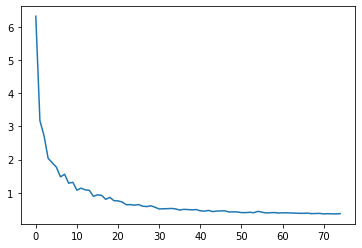

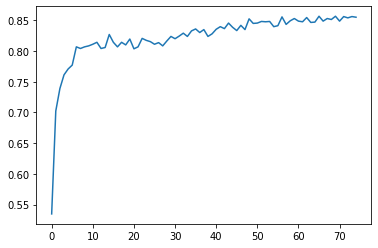

In [ ]:
# warsaw data with dropout

model = Sequential()
model.add(Dense(40, input_dim=len(x_waw.columns), activation=LeakyReLU()))
model.add(GaussianDropout(0.05))
model.add(Dense(20, activation=LeakyReLU()))
model.add(GaussianDropout(0.05))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])

history = model.fit(
    x_waw, y, epochs=75, batch_size=10
)

train_data = pd.DataFrame(history.history)
train_data['loss'].plot(); plt.show()
train_data['accuracy'].plot(); plt.show()



## Przykład predykcji

In [ ]:
input1 = pd.read_csv("dane1.txt").iloc[:, 4:17].drop("('PM2.5', 'Warsaw')", axis=1)
input1.iloc[0, -4] = 0.1
input1.iloc[0, -5] = 8
v = input1.values
input1.T

,0
"('Średnia dobowa wilgotność względna [%]', 'Warsaw')",87.649231
"('Średnia dobowa prędkość wiatru [m/s]', 'Warsaw')",3.353846
"('Maksymalna temperatura dobowa [°C]', 'Warsaw')",2.900000
"('Suma dobowa opadów [mm]', 'Warsaw')",4.000000
"('Temperatura powietrza [°C]', 'Warsaw')",-4.369231
"('Wilgotność względna [%]', 'Warsaw')",87.649231
"('Prędkość wiatru [m/s]', 'Warsaw')",3.353846
"('Zachmurzenie ogólne [0-10 do dn.31.12.1988/oktanty od dn.01.01.1989]', 'Warsaw')",8.000000
"('Widzialność [kod]', 'Warsaw')",0.100000
"('PM10', 'Warsaw')",42.000000


In [ ]:
probability = model.predict(v.reshape(1, -1))[0, 0]
prediction = probability > 0.5
print("\nCzy będzie smog?", prediction, probability)


Czy będzie smog? True 0.5628385


In [ ]:
x_waw.mean()

('Średnia dobowa wilgotność względna [%]', 'Warsaw')                                   73.910239
('Średnia dobowa prędkość wiatru [m/s]', 'Warsaw')                                      2.930381
('Maksymalna temperatura dobowa [°C]', 'Warsaw')                                       12.807701
('Suma dobowa opadów [mm]', 'Warsaw')                                                   1.596174
('Temperatura powietrza [°C]', 'Warsaw')                                               11.286769
('Wilgotność względna [%]', 'Warsaw')                                                  71.871572
('Prędkość wiatru [m/s]', 'Warsaw')                                                     2.930044
('Zachmurzenie ogólne [0-10 do dn.31.12.1988/oktanty od dn.01.01.1989]', 'Warsaw')      5.259819
('Widzialność [kod]', 'Warsaw')                                                         7.198151
('PM10', 'Warsaw')                                                                     40.671373
('NOx', 'Warsaw')             

In [ ]:
sample_input = x_waw.iloc[0]
print(sample_input)

probability = model.predict(sample_input.values.reshape(1, -1))[0, 0]
prediction = probability > 0.5
print("\nCzy będzie smog?", prediction)

('Średnia dobowa wilgotność względna [%]', 'Warsaw')                                  69.500000
('Średnia dobowa prędkość wiatru [m/s]', 'Warsaw')                                     3.000000
('Maksymalna temperatura dobowa [°C]', 'Warsaw')                                      -9.000000
('Suma dobowa opadów [mm]', 'Warsaw')                                                 -1.670671
('Temperatura powietrza [°C]', 'Warsaw')                                              -9.355556
('Wilgotność względna [%]', 'Warsaw')                                                 66.000000
('Prędkość wiatru [m/s]', 'Warsaw')                                                    3.000000
('Zachmurzenie ogólne [0-10 do dn.31.12.1988/oktanty od dn.01.01.1989]', 'Warsaw')     3.500000
('Widzialność [kod]', 'Warsaw')                                                        7.666667
('PM10', 'Warsaw')                                                                    47.862229
('NOx', 'Warsaw')                       